In [3]:
import tifffile as tf
import numpy as np
from matplotlib import pyplot as plt
from glob import glob

In [5]:
src = '/home/eah4d/documents/mcartography/nuclear_mask/'

filenames = glob(src + '*.tif')

In [13]:
np.unique(img)

array([0.0000000e+00, 1.0000000e+00, 1.4142135e+00, ..., 4.8353887e+03,
       4.8357158e+03, 4.8362402e+03], dtype=float32)

In [23]:
i = 4
print(filenames[i])
img = tf.imread(filenames[i])

/home/eah4d/documents/mcartography/nuclear_mask/EDT_A2_nuclearmask.tif


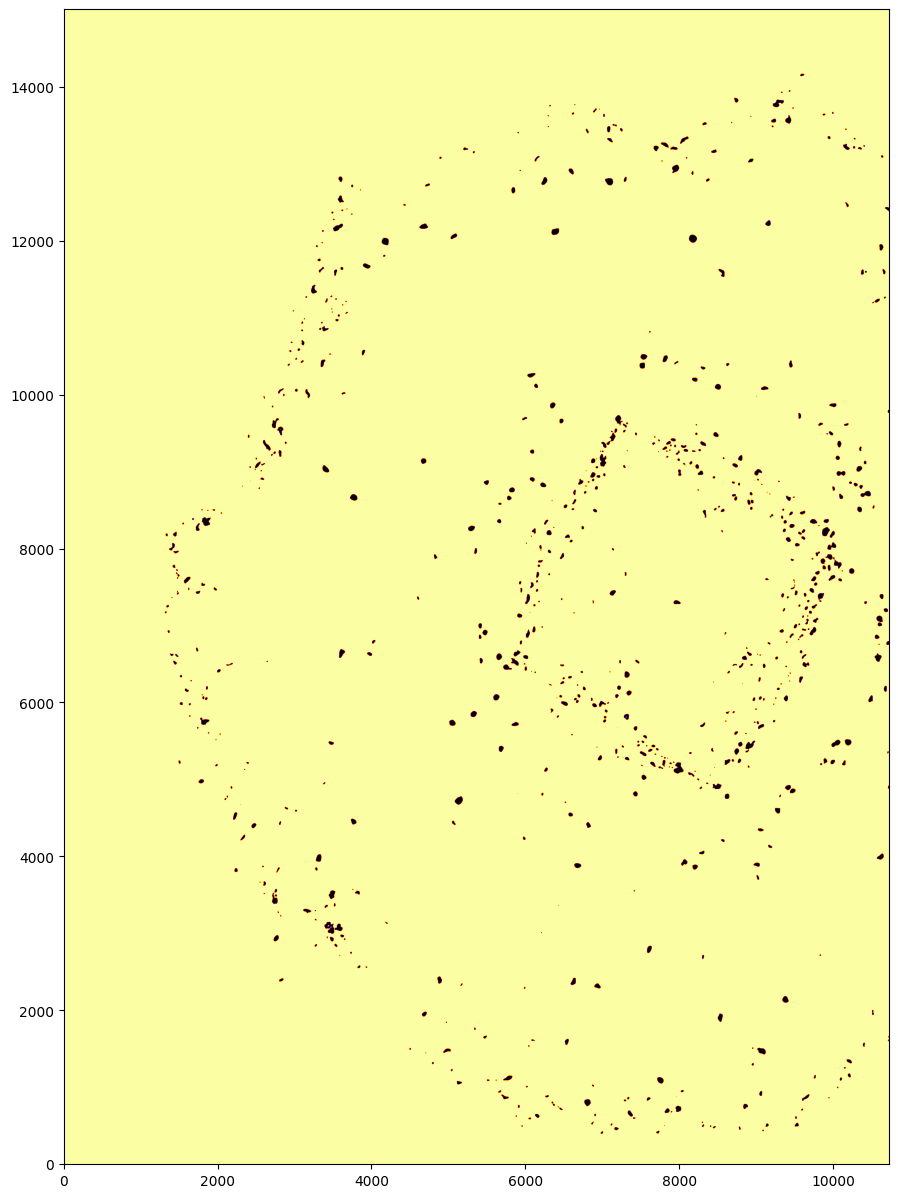

In [24]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

ax.imshow(img > 0, origin='lower', cmap='inferno')

In [66]:
tapes

array([ 885, 1022,  979, 1235, 1441])

5


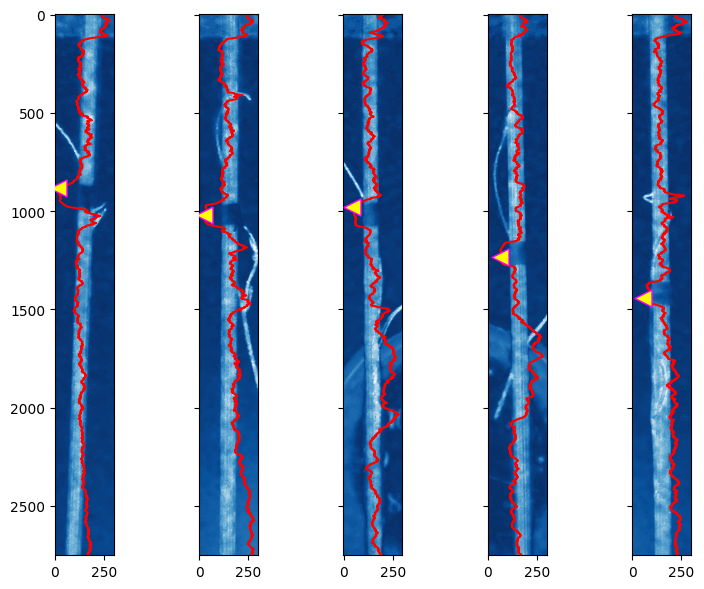

In [8]:
buffx = 0
buffy = 150
stick = []

for i in range(len(peaks)-1):
    stick.append(np.s_[:, peaks[i]-buffy:peaks[i]+buffy])
print(len(stick))
tapes = np.zeros(len(stick), dtype=int)

fig, ax = plt.subplots(1,len(stick),figsize=(8,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    medians = np.sum(s[stick[i]], axis=1)
    foo = 2*(buffy-10)*medians/np.max(medians)
    
    tapes[i] = np.argmin(medians)
    
    ax[i].imshow((s)[stick[i]], vmin=0, cmap='Blues_r')
    ax[i].plot(foo, range(len(foo)), c='r')
    ax[i].scatter([foo[tapes[i]]], [tapes[i]], c='yellow', marker='<', zorder=3, edgecolor='magenta', s=150);
fig.tight_layout();

In [67]:
plants

[(slice(200, 885, None), slice(0, 1240, None)),
 (slice(200, 1022, None), slice(644, 2011, None)),
 (slice(200, 979, None), slice(1340, 2871, None)),
 (slice(200, 1235, None), slice(2111, 3716, None)),
 (slice(200, 1441, None), slice(2971, 4587, None))]

In [9]:
buffx = 200
buffy = 50
plants = []

plants.append(np.s_[buffx:tapes[0], 0:peaks[1]-buffy])

for i in range(1,len(tapes)):
    plants.append(np.s_[buffx:tapes[i], peaks[i-1]+buffy:peaks[i+1]-buffy])

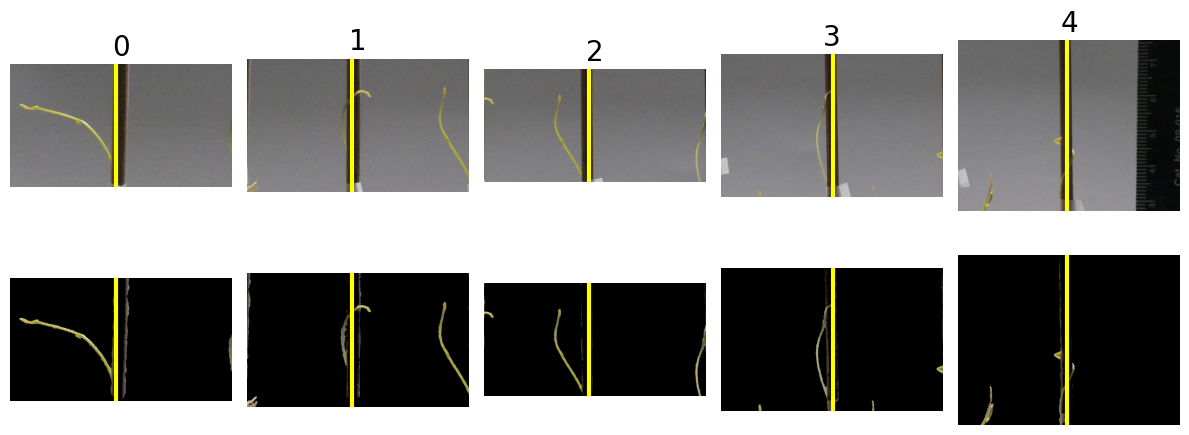

In [10]:
fig, ax = plt.subplots(2,len(plants),figsize=(12,5))
ax = np.atleast_1d(ax).ravel()

for i in range(len(plants)):
    ax[i+len(plants)].imshow(img[plants[i]][:,:,::-1], vmin=0)
    ax[i].imshow(raw[plants[i]][:,:,::-1], vmin=0)
    ax[i].set_title(i, fontsize=20)

    ax[i].axvline(peaks[i]-plants[i][1].start, c='yellow', lw=3)
    ax[i+len(plants)].axvline(peaks[i]-plants[i][1].start, c='yellow', lw=3)
    
for i in range(len(ax)):
    ax[i].axis('off');
    
fig.tight_layout();

In [11]:
i = 1
anchory = peaks[i]-plants[i][1].start

patch = img[plants[i]][:,:,::-1]
rpatch = raw[plants[i]][:,:,::-1]

median = ndimage.median_filter(patch[:,:,1], size=11)
median[median < 50] = 0
median[median > 0] = 1
#median = ndimage.binary_dilation(median, iterations=8)

labels,num = ndimage.label(median, structure=ndimage.generate_binary_structure(median.ndim, 1))

In [12]:
minsize = 100
comp_size = np.zeros(num, dtype=int)
feret = np.zeros((num,2))
touch = np.zeros((num,4))
dtouch = np.zeros((num,2), dtype=int)

for i in range(num):
    box = median.copy()
    box[labels != i+1] = 0

    coords = np.asarray(np.nonzero(box))
    feret[i] = np.max(coords, axis=1) - np.min(coords, axis=1) + np.array([1,1])
    comp_size[i] = len(coords[1])
    
    foo = np.abs(anchory - coords[1])
    
    bar = np.argmin(foo)
    dtouch[i,0] = foo[bar]
    touch[i,:2] = coords[:,bar]
    
    bar = np.argmax(foo)
    dtouch[i,1] = foo[bar]
    touch[i,2:] = coords[:,bar]
    
f_ratio = np.divide(*np.sort(feret, axis=1).T) 

In [ ]:
df = pd.DataFrame(np.column_stack((comp_size, feret, dtouch)), dtype=int,
                  columns = ['size', 'feret_x', 'feret_y', 'd_min', 'd_max'])
df['ratio'] = f_ratio
df

In [13]:
comp_mask = ((feret[:,1] > 50) | (f_ratio > 0.35)) & (comp_size > 100) & (dtouch[:,0] < 50)

size_mask = comp_size/np.sum(comp_size[comp_mask]) > 0.05

mask = comp_mask & size_mask

box = np.zeros_like(labels).astype(bool)
comp_labels = np.nonzero(mask)[0]

for i in comp_labels:
    box[labels == i+1] = True

print(comp_size[comp_mask])
print(comp_size[comp_mask]/np.sum(comp_size[comp_mask]))

[12417]
[1.]


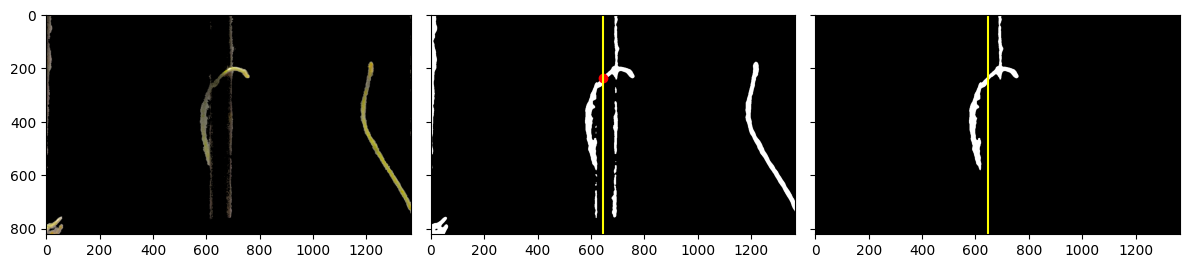

In [14]:
fig, ax = plt.subplots(1,3,figsize=(12,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(patch, origin='lower');

ax[1].imshow(median, cmap='Greys_r', vmax=1)
ax[1].scatter(touch[mask, 1], touch[mask, 0], c='red')
ax[1].axvline(anchory, c='yellow')

ax[2].imshow(box, cmap='Greys_r', vmin=0, vmax=1)
ax[2].axvline(anchory, c='yellow')

fig.tight_layout();

filename = time + '_rep{:02d}_{}_prelim_1'.format(rep, idx+1)

In [15]:
skel = morphology.thin(box)
#scoords = np.asarray(np.nonzero(skel))

In [ ]:
neighs = np.ones((3,3))
neighs[1,1] = 0
neighs = ndimage.convolve(skel.astype(np.uint8), neighs, mode='constant')
print(neighs.dtype)
neighs[skel == 0] = 0

In [ ]:
tips = np.asarray(np.nonzero(neighs == 1))
xroad = np.asarray(np.nonzero(neighs > 2))
dx = dict()
for i in range(len(xroad[0])):
    dx[tuple(xroad[:,i][::-1])] = i

dt = dict()
for i in range(len(tips[0])):
    dt[tuple(tips[:,i][::-1])] = i
dt

In [56]:
comb = box.astype(np.uint8) + skel.astype(np.uint8)

ceros = np.zeros(4, dtype=int)
cero = np.nonzero(np.any(comb != 0, axis = 0))[0][np.asarray([0,-1])]
ceros[:2] = cero

cero = np.nonzero(np.any(comb != 0, axis = 1))[0][np.asarray([0,-1])]
ceros[2:] = cero
ss = np.s_[ceros[2]:ceros[3], ceros[0]:ceros[1]]

4pm_rep07_251_prelim_1


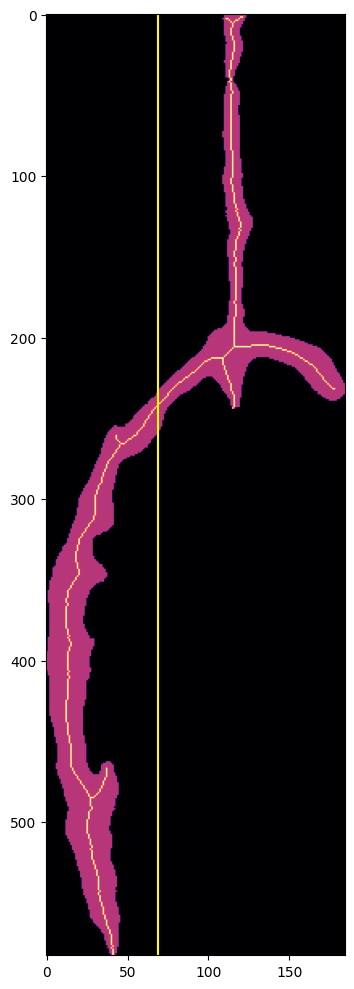

In [61]:
fig, ax = plt.subplots(1,1,figsize=(10,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(comb[ss], cmap='magma', vmin=0, zorder = 2)
#ax[0].scatter([root[0]], [root[1]], marker='D', color='yellow', s=150, edgecolor='red', zorder=10)
#ax[0].scatter(tips[1], tips[0], c='blue', zorder=3, s=10, marker='o')
#ax[0].scatter(xroad[1], xroad[0], c='lime', zorder=4, s=10, marker='X')
ax[0].axvline(anchory - ceros[0], c='yellow', zorder=2)

fig.tight_layout();

filename = time + '_rep{:02d}_{}_prelim_1'.format(rep, idx+1)
print(filename)

In [44]:
ceros

array([577, 762,   0, 583])

In [42]:
cero

array([  0, 583])

In [ ]:


filename = wdst + fname + '_' + tissue[i] + '.tif'
tf.imwrite(filename, tissues[i], photometric='minisblack', compress=3)

In [ ]:
foo = np.argmax(tips[0])
root = tips[:, foo]
root

In [ ]:
ardict = {'W':'E', 'NW':'SE', 'N':'S', 'NE':'SW', 'E':'W', 'SE':'NW', 'S':'N', 'SW':'NE' }

def advance_1step(posx, posy, box):
    arrow = 'null'
    # go left
    if box[posy, posx-1]:
        posx -= 1; arrow='W'
    
    # go NW
    elif box[posy-1, posx-1]:
        posx -= 1; posy -= 1; arrow = 'NW'
    
    # go up
    elif box[posy-1, posx]:
        posy -= 1; arrow = 'N'
        
    # go NE
    elif box[posy-1, posx+1]:
        posx += 1; posy -= 1; arrow = 'NE'
    
    # go right
    elif box[posy, posx+1]:
        posx += 1; arrow = 'E'
    
    # go SE
    elif box[posy+1, posx+1]:
        posx += 1; posy += 1; arrow = 'SE'
        
    # go down
    elif box[posy+1, posx]:
        posy += 1; arrow = 'S'
    
    # go SW
    elif box[posy+1, posx-1]:
        posx -= 1; posy += 1; arrow = 'SW'
        
    return tuple([posx, posy]), arrow

In [ ]:
skelcpy = skel.copy()
crawl = True
vine = []
arrs = []
posy, posx = root
vine.append([posx, posy])

itlim = 1000

i = 0
while (i < itlim) & crawl:
    skelcpy[posy, posx] = False
    i += 1
    
    foo, arrow = advance_1step(posx, posy, skelcpy)
    
    nx, ny = foo
    if arrow == 'null':
        crawl = False
    else:
        posx = nx
        posy = ny
        vine.append([posx, posy])
        
        if (foo in dx) | (foo in dt):
            crawl = False
            
vine = np.asarray(vine)
len(vine)

In [ ]:
buff = 10
view = np.s_[vine[-1,1]-buff:vine[-1,1]+buff, vine[-1,0]-buff:vine[-1,0]+buff]
#foo = box.astype(int) + mtax.astype(int)

plt.imshow(skel[view])
plt.axvline(buff, c='r', lw=1)
plt.axhline(buff, c='r', lw=1);

In [ ]:
dx

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()
ss = np.s_[750:, 600:800]
ss = np.s_[350:, 500:800]

ax[0].imshow(skel, cmap='magma', vmin=0, zorder = 2)
#ax[0].scatter([root[0]], [root[1]], marker='D', color='yellow', s=150, edgecolor='red', zorder=10)
ax[0].scatter(tips[1], tips[0], c='blue', zorder=6, s=25, marker='o')
ax[0].scatter(xroad[1], xroad[0], c='lime', zorder=5, s=25, marker='X')
ax[0].scatter(vine[:,0], vine[:,1], c='m', zorder=4, s=10, marker='*')
ax[0].axvline(anchory, c='yellow', zorder=2)

fig.tight_layout();

filename = time + '_rep{:02d}_{}_prelim_1'.format(rep, idx+1)

In [ ]:
coords = np.asarray(np.nonzero(box))
root = np.max(coords[0])
foo = coords[:,coords[0] == root]
foo = np.min(foo[1])
root = np.array([foo, root])
print('Root:\t', root)

In [ ]:
vine = []
advance_nw = True
advance_ne = False

posx, posy = root
jumplim = 25

while advance_nw:
    vine.append(np.array([posx, posy]))
    
    # go left
    if box[posy, posx-1]:
        posx -= 1
    
    # go NW
    elif box[posy-1, posx-1]:
        posx -= 1; posy -= 1
    
    # go up
    elif box[posy-1, posx]:
        posy -= 1
        
    # go NE
    #elif box[posy-1, posx+1]:
    #    posx += 1; posy -= 1
    
    # try jumping
    else:
        #advance_nw = False
        jumparr = np.nonzero(box[posy-jumplim:posy, posx])[0]
        
        # jump up
        if len(jumparr) > 0:
            jump = jumplim - jumparr[-1]
            posy -= jump
    
        else:
            advance_nw = False

while advance_ne:
    vine.append(np.array([posx, posy]))
    
    # go NE
    if box[posy-1, posx+1]:
        posx += 1; posy -= 1
        
    # go left
    elif box[posy, posx+1]:
        posx += 1
    
    else:
        advance_ne = False
            

vine = np.asarray(vine)
len(vine)

In [ ]:
buff = jumplim
buff = jumplim*10
view = np.s_[vine[-1,1]-buff:vine[-1,1]+buff, vine[-1,0]-buff:vine[-1,0]+buff]
#foo = box.astype(int) + mtax.astype(int)

plt.imshow(box[view])
plt.axvline(buff, c='r', lw=1)
plt.axhline(buff, c='r', lw=1);

In [ ]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [ ]:
peaks

In [ ]:
jdx = 4
fig, ax = plt.subplots(2,len(stick),figsize=(12,10))

ax = ax.ravel()

for i in range(len(stick)):
    ax[i].imshow(img[stick[i]][:,:,::-1]);
    ax[i].axis('off')
    
    ax[i+5].imshow(np.max(img[stick[i]], axis=2), vmax=1)
    ax[i+5].axis('off')

fig.tight_layout()

In [ ]:
i = 0

hsv = cv2.cvtColor(img[stick[i]], cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

fig, ax = plt.subplots(1,4,figsize=(12,7), sharex=True, sharey=True)

ax[0].imshow(h, cmap='inferno');
ax[1].imshow(s, cmap='inferno');
ax[2].imshow(v, cmap='inferno', vmin=0, vmax=255);
ax[3].imshow(img[stick[i]])

fig.tight_layout()

In [ ]:
plt.imshow(v > 62, cmap='Greys_r');